# CS72 Final Project: Zipf's Law and Word Embeddings

Harrison Stropkay (harrison.f.stropkay.25@dartmouth.edu)

Professor Rolando Coto-Solano 

June 4, 2024

This notebook serves as the final project for CS72: Data Science at Dartmouth College. The project is an exploration of Zipf's Law and word embeddings. The project is broken into two parts: data collation and experiments. In the data collation section, I will gather data word count data and word embeddings from various word embedding models and languages. In the experiments section, I will investigate the relationship between word embedding magnitudes and word frequencies, aiming to find an analog to Zipf's Law in the word embedding space.

All data and experiments can be generated by this notebook except the Chinese Word2Vec embeddings, which are from the Mixed-large dataset at https://github.com/Embedding/Chinese-Word-Vectors?tab=readme-ov-file. 

In [20]:
import pandas as pd
import os
import chardet
from multiprocessing import Pool
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import spearmanr, pearsonr
import gensim
from xml.etree import ElementTree as ET
from nltk.tokenize.stanford_segmenter import StanfordSegmenter
import multiprocessing
from tqdm import tqdm
import fasttext.util
import gensim.downloader as gensim_api

In [21]:
sns.set_theme(style="whitegrid")

# Data collation

## Wikipedia word frequencies

Data credit: https://github.com/IlyaSemenov/wikipedia-word-frequency/

In [22]:
languages_data = {
    "afrikaans": {
        "code": "af",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/afwiki-2024-02-20.txt",
    },
    "arabic": {
        "code": "ar",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/arwiki-2022-08-29.txt",
    },
    "cebuano": {
        "code": "ceb",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/cebwiki-2024-02-20.txt",
    },
    "german": {
        "code": "de",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/dewiki-2022-08-29.txt",
    },
    "english": {
        "code": "en",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/enwiki-2023-04-13.txt",
    },
    "spanish": {
        "code": "es",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/eswiki-2022-08-29.txt",
    },
    "french": {
        "code": "fr",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/frwiki-2022-08-29.txt",
    },
    "italian": {
        "code": "it",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/itwiki-2022-08-30.txt",
    },
    "japanese": {
        "code": "ja",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/jawiki-2022-08-29.txt",
    },
    "dutch": {
        "code": "nl",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/nlwiki-2022-08-29.txt",
    },
    "polish": {
        "code": "pl",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/plwiki-2022-08-29.txt",
    },
    "portuguese": {
        "code": "pt",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/ptwiki-2022-08-29.txt",
    },
    "russian": {
        "code": "ru",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/ruwiki-2022-08-29.txt",
    },
    "swedish": {
        "code": "sv",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/svwiki-2022-08-30.txt",
    },
    "swahili": {
        "code": "sw",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/swwiki-2024-02-20.txt",
    },
    "ukrainian": {
        "code": "uk",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/ukwiki-2022-08-30.txt",
    },
    "vietnamese": {
        "code": "vi",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/viwiki-2022-08-30.txt",
    },
    "chinese": {
        "code": "zh",
        "url": "https://raw.githubusercontent.com/IlyaSemenov/wikipedia-word-frequency/master/results/zhwiki-2022-08-30.txt",
    },
}

In [23]:
import gensim.downloader

print(list(gensim.downloader.info()["models"].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


## Download word frequencies and fastText models for varying languages

In [24]:
model_dir = "data/models"

for language, data in languages_data.items():
    if os.path.exists(f"data/counts/{language}.csv"):
        print(f"{language} data already downloaded")
    else:
        print(f"Downloading {language} data")
        df = pd.read_csv(data["url"], sep=" ", header=None, names=["word", "count"])
        df.to_csv(f"data/counts/{language}.csv", index=False)

    if os.path.exists(f"data/models/cc.{data['code']}.300.bin"):
        print(f"{language} model already downloaded")
    else:
        print(f"Downloading {language} model")
        # change directory to the model directory
        os.chdir(model_dir)
        fasttext.util.download_model(data["code"], if_exists="ignore")
        # change directory back to the original directory
        os.chdir("../..")

afrikaans data already downloaded
afrikaans model already downloaded
arabic data already downloaded
arabic model already downloaded
cebuano data already downloaded
cebuano model already downloaded
german data already downloaded
german model already downloaded
english data already downloaded
english model already downloaded
spanish data already downloaded
spanish model already downloaded
french data already downloaded
french model already downloaded
italian data already downloaded
italian model already downloaded
japanese data already downloaded
japanese model already downloaded
dutch data already downloaded
dutch model already downloaded
polish data already downloaded
polish model already downloaded
portuguese data already downloaded
portuguese model already downloaded
russian data already downloaded
russian model already downloaded
swedish data already downloaded
swedish model already downloaded
swahili data already downloaded
swahili model already downloaded
ukrainian data already do

## Combine embeddings and word frequencies

### Gensim embeddings

To compare Word2Vec and GloVe embeddings with fastText while holding the language constant.

In [25]:
gensim_dict = {
    "english-word2vec": "word2vec-google-news-300",
    "english-glove": "glove-wiki-gigaword-300",
    "english-fasttext": "fasttext-wiki-news-subwords-300",
}


for model_name, model_id in gensim_dict.items():
    language = model_name.split("-")[0]
    df_counts = pd.read_csv(f"data/counts/{language}.csv")

    output_name = f"data/final/{model_name}.csv"
    if os.path.exists(output_name):
        print(f"{model_name} already collated")
        continue

    print(f"Downloading {model_name} model")
    model = gensim_api.load(model_id)

    df_magnitude = []
    for word in model.key_to_index:
        embedding = model.get_vector(word)
        magnitude = np.linalg.norm(embedding)
        df_magnitude.append({"word": word, "magnitude": magnitude})
    df_magnitude = pd.DataFrame(df_magnitude)

    df_merged = pd.merge(df_counts, df_magnitude, on="word", how="inner")
    df_merged["frequency"] = df_merged["count"] / df_merged["count"].sum()
    df_merged["frequency_rank"] = df_merged["frequency"].rank(ascending=False)
    df_merged["magnitude_rank"] = df_merged["magnitude"].rank(ascending=False)

    # Keep only the top 100,000 by frequency rank
    df_merged = df_merged.sort_values("frequency_rank").head(100000)

    df_merged.to_csv(output_name, index=False)

english-word2vec already collated
english-glove already collated
english-fasttext already collated


### fastText embeddings 

To compare word embeddings across languages while holding the emebedding model constant. 

In [26]:
for language, data in languages_data.items():
    if os.path.exists(f"data/final/{language}.csv"):
        print(f"{language} final dataset already generated")
        continue

    print(f"Generating {language} final dataset")
    df_counts = pd.read_csv(f"data/counts/{language}.csv")

    ft = fasttext.load_model(f"data/models/cc.{data['code']}.300.bin")

    df_magnitudes = []
    for word in df_counts["word"]:
        try:
            vec = ft.get_word_vector(word)
            magnitude = np.linalg.norm(vec)
            df_magnitudes.append({"word": word, "magnitude": magnitude})
        except:
            pass
    df_magnitudes = pd.DataFrame(df_magnitudes)
    df_merged = pd.merge(df_counts, df_magnitudes, on="word")

    df_merged["frequency"] = df_merged["count"] / df_merged["count"].sum()
    df_merged["frequency_rank"] = df_merged["frequency"].rank(ascending=False)
    df_merged["magnitude_rank"] = df_merged["magnitude"].rank(ascending=False)

    # Only keep the top 100,000 words by frequency rank
    df_merged = df_merged.sort_values("frequency_rank").head(100000)
    df_merged.to_csv(f"data/final/{language}.csv", index=False)

afrikaans final dataset already generated
arabic final dataset already generated
cebuano final dataset already generated
german final dataset already generated
english final dataset already generated
spanish final dataset already generated
french final dataset already generated
italian final dataset already generated
japanese final dataset already generated
dutch final dataset already generated
polish final dataset already generated
portuguese final dataset already generated
russian final dataset already generated
swedish final dataset already generated
swahili final dataset already generated
ukrainian final dataset already generated
vietnamese final dataset already generated
chinese final dataset already generated


### Chinese word2vec

https://github.com/Embedding/Chinese-Word-Vectors?tab=readme-ov-file

300 Mixed-large

In [27]:
import bz2


file_path = "data/extra/sgns.merge.word.bz2"
output_path = "data/final/chinese-word2vec.csv"

if not os.path.exists(output_path):
    print("Generating Chinese Word2Vec dataset")

    df_magnitudes = []
    with bz2.open(file_path, "rt") as f:
        lines = f.readlines()
        for line in lines:
            parts = line.split()
            word = parts[0]
            embedding = np.array([float(x) for x in parts[1:]])
            magnitude = np.linalg.norm(embedding)
            df_magnitudes.append({"word": word, "magnitude": magnitude})
    df_magnitudes = pd.DataFrame(df_magnitudes)
    df_counts = pd.read_csv("data/counts/chinese.csv")
    df_merged = pd.merge(df_counts, df_magnitudes, on="word")
    df_merged["frequency"] = df_merged["count"] / df_merged["count"].sum()
    df_merged["frequency_rank"] = df_merged["frequency"].rank(ascending=False)
    df_merged["magnitude_rank"] = df_merged["magnitude"].rank(ascending=False)
    df_merged = df_merged.sort_values("frequency_rank").head(100000)
    df_merged.to_csv(output_path, index=False)
else:
    print("Chinese Word2Vec dataset already generated")

Chinese Word2Vec dataset already generated


# Experiments

## Confirming Zipf's Law

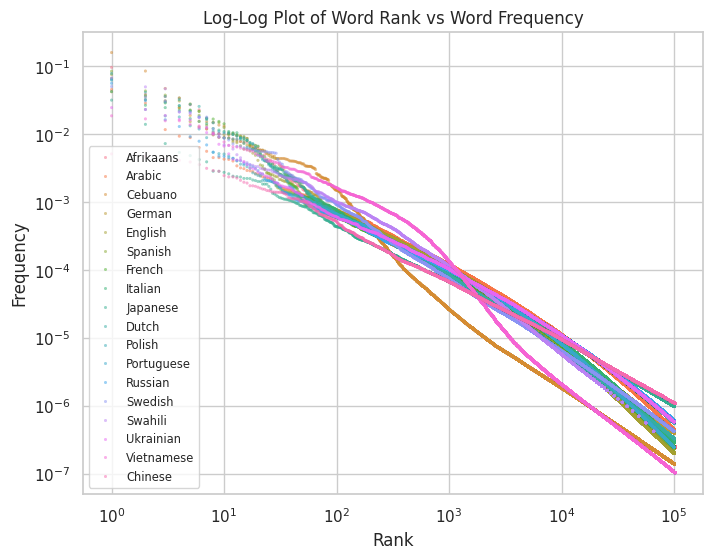

language
Afrikaans    -0.997200
Arabic       -0.993813
Cebuano      -0.998123
Chinese      -0.999515
Dutch        -0.998507
English      -0.995226
French       -0.993929
German       -0.998082
Italian      -0.993267
Japanese     -0.998881
Polish       -0.994807
Portuguese   -0.993510
Russian      -0.994979
Spanish      -0.993551
Swahili      -0.998253
Swedish      -0.999283
Ukrainian    -0.995262
Vietnamese   -0.995812
Name: pearson_r, dtype: float64


In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import pearsonr


# Define the new power law function with only parameter c
def power_law(x, c):
    return c / x


# Function to load data, fit the curve, and return the necessary data
def process_language_data(language):
    df = pd.read_csv(f"data/final/{language}.csv")
    df["rank"] = df["frequency_rank"]
    df["frequency"] = df["frequency"]
    df["language"] = language.capitalize()

    x_data = df["rank"].values
    y_data = df["frequency"].values

    # Fit the curve with the new function
    params, _ = curve_fit(power_law, x_data, y_data)
    c_best_fit = params[0]

    df["c_best_fit"] = c_best_fit

    # Calculate predicted y values
    y_pred = power_law(x_data, c_best_fit)

    # Calculate Pearson's r
    pearson_r, _ = pearsonr(np.log(x_data), np.log(y_data))
    df["pearson_r"] = pearson_r

    return df


# Concatenate all dataframes
df_all = pd.concat(
    [process_language_data(language) for language in languages_data.keys()],
    ignore_index=True,
)

# Plot the data and the best fit curves using seaborn
plt.figure(figsize=(8, 6))

# Scatter plot
sns.scatterplot(
    data=df_all,
    x="rank",
    y="frequency",
    hue="language",
    s=4,
    edgecolor=None,
    alpha=0.5,
)

plt.ylabel("Frequency")
plt.xlabel("Rank")
plt.xscale("log")
plt.yscale("log")
plt.title("Log-Log Plot of Word Rank vs Word Frequency")
plt.legend(loc="lower left", fontsize="x-small")
plt.show()

# Display Pearson's r for each language
print(df_all.groupby("language")["pearson_r"].first())

## Experiments varying word embedding models

In [29]:
model_data = {
    "word2vec": "english-word2vec",
    "glove": "english-glove",
    "fasttext": "english-fasttext",
}

Word2Vec MAE: 0.010860436942749902
GloVe MAE: 0.004443408869698029
FastText MAE: 0.02700530732412182


/tmp/ipykernel_2092549/62001976.py:44: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x)
/home2/hstropkay/72/72-final-project/.venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T


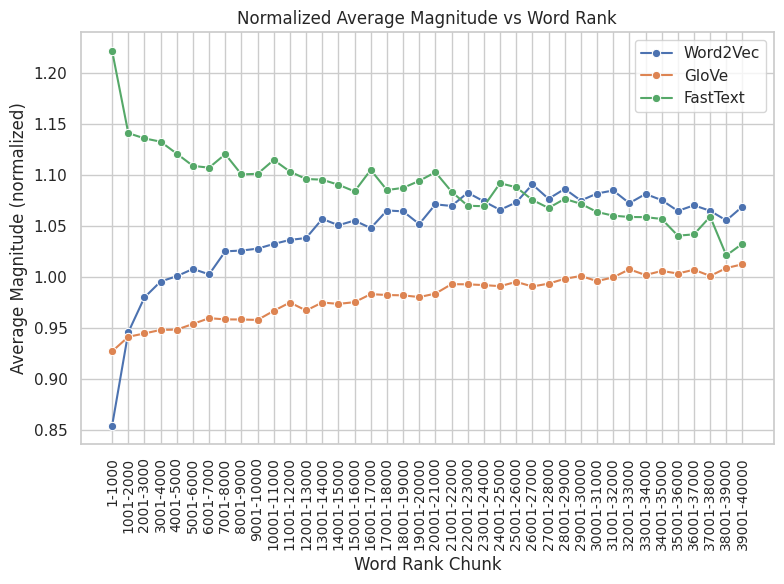

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


num_words_per_chunk = 1000
num_chunks = 40

avg_magnitudes = []
for model, modelname in model_data.items():
    # Read the data for the model
    df = pd.read_csv(f"data/final/{modelname}.csv")
    df = df.sort_values("frequency_rank")

    # Normalize magnitudes so the average magnitude of the dataset is 1
    avg_magnitude_dataset = df["magnitude"].mean()
    df["magnitude"] = df["magnitude"] / avg_magnitude_dataset

    # Calculate average magnitude for each chunk
    for i in range(num_chunks):
        chunk_start = i * num_words_per_chunk
        chunk_end = chunk_start + num_words_per_chunk
        chunk = df.iloc[chunk_start:chunk_end]
        avg_magnitude = chunk["magnitude"].mean()

        avg_magnitudes.append(
            {
                "Word Rank Chunk": f"{chunk_start + 1}-{chunk_end}",
                "Average Magnitude": avg_magnitude,
                "model": model,
            }
        )

# Convert to DataFrame
data = pd.DataFrame(avg_magnitudes)
# Replace model names with more readable names
data["model"] = data["model"].replace(
    {"word2vec": "Word2Vec", "glove": "GloVe", "fasttext": "FastText"}
)


# Define a logarithmic function to fit
def log_func(x, a, b):
    return a * np.log(b * x)


# Fit the data and print mse for each model
for model in data["model"].unique():

    df = data[data["model"] == model]

    # Fit the log curve
    x = df["Word Rank Chunk"].str.split("-", expand=True)[1].astype(int).values
    y = df["Average Magnitude"].values
    opt, _ = curve_fit(log_func, x, y, maxfev=10000)
    y_fit = log_func(x, *opt)

    # Calculate MAE
    mse = np.mean(np.abs(y - y_fit))
    print(f"{model} MAE: {mse}")


# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=data,
    x="Word Rank Chunk",
    y="Average Magnitude",
    hue="model",
    marker="o",
)
plt.xticks(rotation=90, fontsize="small")
plt.xlabel("Word Rank Chunk")
plt.ylabel("Average Magnitude (normalized)")
plt.title(f"Normalized Average Magnitude vs Word Rank")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_2092549/2257312066.py:57: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


FastText Pearson fit MSA: 0.08645814790198862
FastText Spearman's rank fit MSA: 0.09844787079918826
GloVe Pearson fit MSA: 0.05051779174843919
GloVe Spearman's rank fit MSA: 0.07190977502036328
Word2Vec Pearson fit MSA: 0.03262417073540926
Word2Vec Spearman's rank fit MSA: 0.06878179050569572


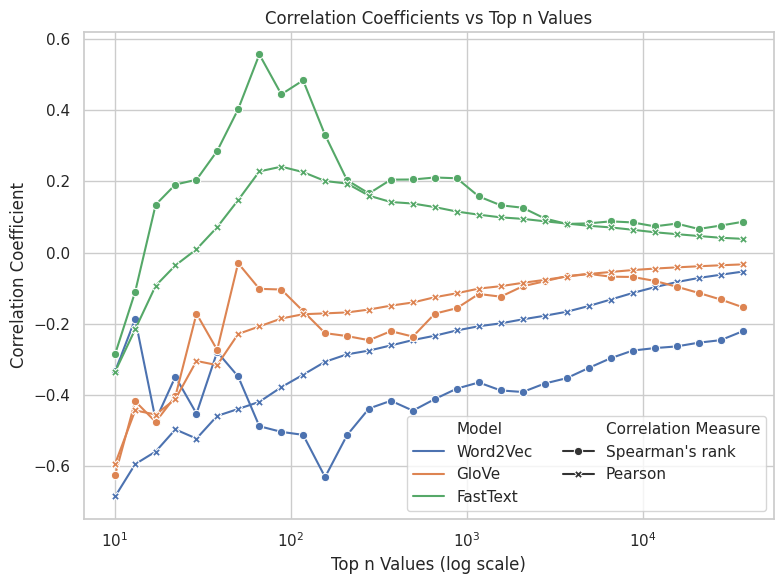

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from scipy.optimize import curve_fit

# Assuming model_data dictionary is defined as { 'model1': 'modelname1', 'model2': 'modelname2', ...}
# model_data = {...}

start_value = 10
ratio = 10 ** (1 / 8)
cap = 40000
top_n_values = []
while start_value <= cap:
    top_n_values.append(start_value)
    start_value = int(start_value * ratio)

correlations = []
for model, modelname in model_data.items():
    for top_n in top_n_values:
        df_model = pd.read_csv(f"data/final/{modelname}.csv")
        df_model = df_model.head(top_n)

        # Calculate the correlation coefficients
        spearman_corr, _ = spearmanr(
            df_model["magnitude_rank"], df_model["frequency_rank"]
        )
        pearson_corr, _ = pearsonr(df_model["magnitude"], df_model["frequency"])

        correlations.append(
            {
                "Top N Values": top_n,
                "Correlation Coefficient": spearman_corr,
                "Correlation Measure": "Spearman's rank",
                "Model": model,
            }
        )
        correlations.append(
            {
                "Top N Values": top_n,
                "Correlation Coefficient": pearson_corr,
                "Correlation Measure": "Pearson",
                "Model": model,
            }
        )

data = pd.DataFrame(correlations)
# change glove to GloVe, fasttext to FastText, and word2vec to Word2Vec
data["Model"] = data["Model"].str.replace("glove", "GloVe")
data["Model"] = data["Model"].str.replace("fasttext", "FastText")
data["Model"] = data["Model"].str.replace("word2vec", "Word2Vec")


# Define a logarithmic function to fit
def log_func(x, a, b, c):
    return a * np.log(b * x) + c


# Plot and fit curves
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=data,
    x="Top N Values",
    y="Correlation Coefficient",
    hue="Model",
    style="Correlation Measure",
    dashes=False,
    markers=True,
)
plt.xscale("log")
plt.xlabel("Top n Values (log scale)")
plt.ylabel("Correlation Coefficient")
plt.title(f"Correlation Coefficients vs Top n Values")
plt.legend(loc="lower right", fontsize="x-small")
plt.grid(True)
plt.tight_layout()

# Fit the log curve for each combination and calculate MSE
for (model, corr_measure), group_data in data.groupby(["Model", "Correlation Measure"]):
    x = group_data["Top N Values"].values
    y = group_data["Correlation Coefficient"].values
    popt, _ = curve_fit(log_func, x, y)
    y_fit = log_func(x, *popt)

    # Calculate MSA
    msa = np.mean(np.abs(y - y_fit))

    print(f"{model} {corr_measure} fit MSA: {msa}")

plt.legend(loc="lower right", ncol=2)
plt.show()

## Experiments varying languages

### FastText

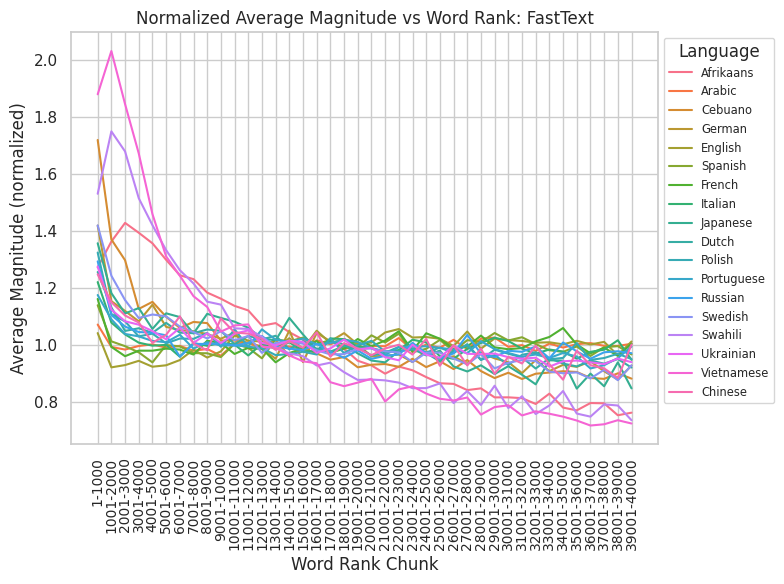

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


num_words_per_chunk = 1000
num_chunks = 40

avg_magnitudes = []
for language in languages_data.keys():
    # Read the data for the model
    df = pd.read_csv(f"data/final/{language}.csv")
    df = df.sort_values("frequency_rank")
    df = df.head(num_words_per_chunk * num_chunks)

    # Normalize magnitudes so the average magnitude of the dataset is 1
    avg_magnitude_dataset = df["magnitude"].mean()
    df["magnitude"] = df["magnitude"] / avg_magnitude_dataset

    # Calculate average magnitude for each chunk
    for i in range(num_chunks):
        chunk_start = i * num_words_per_chunk
        chunk_end = chunk_start + num_words_per_chunk
        chunk = df.iloc[chunk_start:chunk_end]
        avg_magnitude = chunk["magnitude"].mean()

        avg_magnitudes.append(
            {
                "Word Rank Chunk": f"{chunk_start + 1}-{chunk_end}",
                "Average Magnitude": avg_magnitude,
                "Language": language,
            }
        )

data = pd.DataFrame(avg_magnitudes)
# Capitalize the first letter of the language names
data["Language"] = data["Language"].str.capitalize()

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=data,
    x="Word Rank Chunk",
    y="Average Magnitude",
    hue="Language",
    # make the x-axis labels more readable, font size smaller
)
plt.xticks(rotation=90, fontsize="small")
plt.xlabel("Word Rank Chunk")
plt.ylabel("Average Magnitude (normalized)")
plt.title(f"Normalized Average Magnitude vs Word Rank: FastText")
plt.legend(
    loc="upper left", bbox_to_anchor=(1, 1), fontsize="x-small", title="Language"
)
plt.grid(True)
plt.tight_layout()
plt.show()

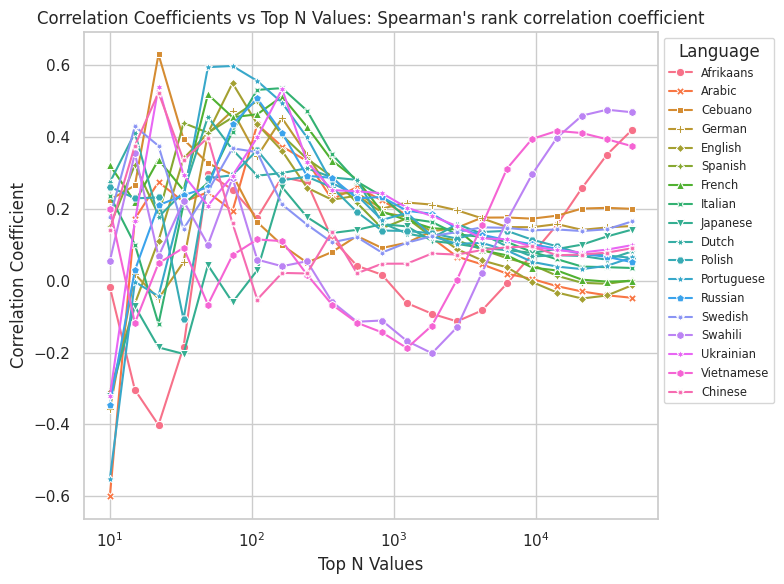

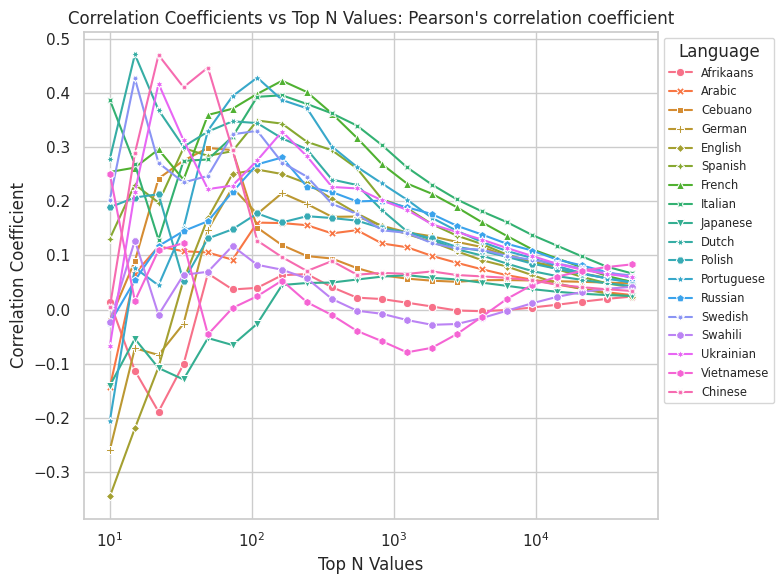

In [33]:
start_value = 10
ratio = 1.5
cap = 50000
top_n_values = []
while start_value <= cap:
    top_n_values.append(start_value)
    start_value = int(start_value * ratio)

correlations = []
for language in languages_data.keys():
    for top_n in top_n_values:
        df_model = pd.read_csv(f"data/final/{language}.csv")
        df_model = df_model.head(top_n)

        # Calculate the correlation coefficients
        spearman_corr, _ = spearmanr(
            df_model["magnitude_rank"], df_model["frequency_rank"]
        )
        pearson_corr, _ = pearsonr(df_model["magnitude"], df_model["frequency"])

        correlations.append(
            {
                "Top N Values": top_n,
                "Correlation Coefficient": spearman_corr,
                "Correlation Measure": "Spearman's rank correlation coefficient",
                "Language": language,
            }
        )
        correlations.append(
            {
                "Top N Values": top_n,
                "Correlation Coefficient": pearson_corr,
                "Correlation Measure": "Pearson's correlation coefficient",
                "Language": language,
            }
        )

for correlation_measure in [
    "Spearman's rank correlation coefficient",
    "Pearson's correlation coefficient",
]:
    df = pd.DataFrame(correlations)
    df = df[df["Correlation Measure"] == correlation_measure]
    df["Language"] = df["Language"].str.capitalize()

    plt.figure(figsize=(8, 6))
    sns.lineplot(
        data=df,
        x="Top N Values",
        y="Correlation Coefficient",
        hue="Language",
        style="Language",
        dashes=False,
        markers=True,
    )
    plt.xscale("log")
    plt.xlabel("Top N Values")
    plt.ylabel("Correlation Coefficient")
    plt.title(f"Correlation Coefficients vs Top N Values: {correlation_measure}")
    plt.legend(
        loc="upper left", bbox_to_anchor=(1, 1), fontsize="x-small", title="Language"
    )
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Word2vec

/tmp/ipykernel_2092549/2444182570.py:42: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c
/tmp/ipykernel_2092549/2444182570.py:42: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c


English MSE: 0.0002304190055913119
Chinese MSE: 0.00013258501079093963


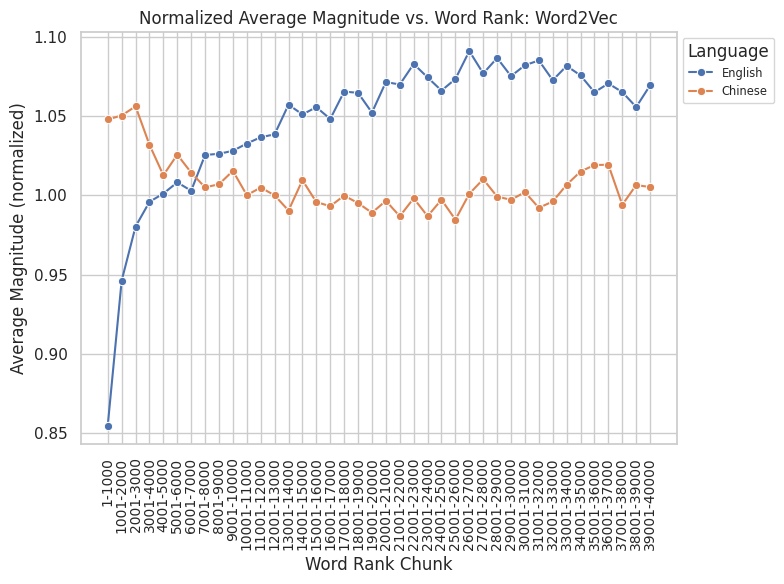

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


num_words_per_chunk = 1000
num_chunks = 40

avg_magnitudes = []
for language in ["english", "chinese"]:
    # Read the data for the model
    df = pd.read_csv(f"data/final/{language}-word2vec.csv")
    df = df.sort_values("frequency_rank")

    # Normalize magnitudes so the average magnitude of the dataset is 1
    avg_magnitude_dataset = df["magnitude"].mean()
    df["magnitude"] = df["magnitude"] / avg_magnitude_dataset

    # Calculate average magnitude for each chunk
    for i in range(num_chunks):
        chunk_start = i * num_words_per_chunk
        chunk_end = chunk_start + num_words_per_chunk
        chunk = df.iloc[chunk_start:chunk_end]
        avg_magnitude = chunk["magnitude"].mean()

        avg_magnitudes.append(
            {
                "Word Rank Chunk": f"{chunk_start + 1}-{chunk_end}",
                "Average Magnitude": avg_magnitude,
                "Language": language,
            }
        )

data = pd.DataFrame(avg_magnitudes)
data["Language"] = data["Language"].replace(
    {"english": "English", "chinese": "Chinese"}
)


# Define a logarithmic function to fit
def log_func(x, a, b, c):
    return a * np.log(b * x) + c


# Fit the data and print r squared for each language
for language in data["Language"].unique():

    df = data[data["Language"] == language]

    # Fit the log curve
    x = df["Word Rank Chunk"].str.split("-", expand=True)[1].astype(int).values
    y = df["Average Magnitude"].values
    popt, _ = curve_fit(log_func, x, y)
    a, b, c = popt
    y_fit = log_func(x, a, b, c)

    # Calculate MSE
    mse = np.mean((y - y_fit) ** 2)
    print(f"{language} MSE: {mse}")


# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=data,
    x="Word Rank Chunk",
    y="Average Magnitude",
    hue="Language",
    marker="o",
)
plt.xticks(rotation=90, fontsize="small")
plt.xlabel("Word Rank Chunk")
plt.ylabel("Average Magnitude (normalized)")
plt.title(f"Normalized Average Magnitude vs. Word Rank: Word2Vec")
plt.legend(
    loc="upper left", bbox_to_anchor=(1, 1), fontsize="x-small", title="Language"
)
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# In the English word2vec model, print row for "the" and "chlorophyll"
df = pd.read_csv("data/final/english-word2vec.csv")
for column in df.columns:
    print(f"{column}: {df[df['word'] == 'the'][column].values[0]}")
    print(f"{column}: {df[df['word'] == 'chlorophyll'][column].values[0]}")

word: the
word: chlorophyll
count: 186631452
count: 2147
magnitude: 1.0722071
magnitude: 4.4882674
frequency: 0.091593851221617
frequency: 1.0536916284229078e-06
frequency_rank: 1.0
frequency_rank: 29897.0
magnitude_rank: 139050.0
magnitude_rank: 3334.0
